Project Task 1 - Basic Classifiers and Evaluation

1) Prepare the dataset in order to build several basic classifiers able to predict room occupancy from the available variables. You are welcome in creating new variables.

2) Solve the classification task with k-NN (testing values of k), Naive Bayes, Logistic Regression, Decision Tree using cross-validation and/or random/grid search for parameter estimation.

3) Evaluate each classifier using Accuracy, Precision, Recall, F1, ROC, AUC and Lift Chart.

4) Try to reduce the dimensionality of the dataset using the methods studied (or new ones). Test PCA and try to solve the classification task in two dimensions. Plot the dataset in the two new dimensions and observe the decision boundary and the one of the trained algorithms.

5) Analyze the value distribution of the class to predict and turn the dataset into an imbalanced version reaching a strong majority-minority distribution (e.g. 96%-4%). Then solve again the classification task adopting the various techniques studied (or new ones).

6) Select two continuous attributes, define a regression problem and try to solve it using different techniques reporting various evaluation measures. Plot the two-dimensional dataset. Then generalize to multiple linear regression and observe how the performance varies.

7) Draw your conclusions about the basic classifiers and techniques adopted in this analysis.


In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [20]:
df_test1 = pd.read_csv("datatest.txt")

In [21]:
df_test2 = pd.read_csv("datatest2.txt")

In [22]:
df = pd.read_csv("datatraining.txt")

In [23]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [24]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
date             8143 non-null object
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


In [26]:
#aggiunta variabili ora e data scomponendo 'date'
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['hour'] = dates.dt.hour

In [27]:
#aggiunta variabile binaria weekend
weekend = []
for i in df.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
df['weekend'] = weekend

In [28]:
#aggiunta variabile binaria daylight
daylight = []
for i in df.hour:
    if i >= 7 and i <= 17:
        daylight.append(1)
    else:
        daylight.append(0)
daylight = pd.Series(daylight)
df['daylight'] = daylight

In [29]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,weekend,daylight
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,4,17,0.0,1.0
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,4,17,0.0,1.0
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,4,17,0.0,1.0
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,4,17,0.0,1.0
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,4,17,0.0,1.0


# DATA PARTITIONING

In [30]:
# Remove "date" from dataset because gives us an error
df = df[['Temperature', 'Humidity', 'Light', 'CO2', 'Occupancy', 'day',
       'hour', 'weekend', 'daylight']]

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [32]:
class_name = "Occupancy"

In [33]:
prepare_dataset(df, class_name)

(      Temperature   Humidity  Light         CO2  day  hour   weekend  \
 1       23.180000  27.272000  426.0  721.250000    4    17  0.000000   
 2       23.150000  27.267500  429.5  714.000000    4    17  0.000000   
 3       23.150000  27.245000  426.0  713.500000    4    17  0.000000   
 4       23.150000  27.200000  426.0  708.250000    4    17  0.000000   
 5       23.100000  27.200000  426.0  704.500000    4    17  0.000000   
 6       23.100000  27.200000  419.0  701.000000    4    17  0.000000   
 7       23.100000  27.200000  419.0  701.666667    4    17  0.000000   
 8       23.100000  27.200000  419.0  699.000000    4    17  0.000000   
 9       23.100000  27.200000  419.0  689.333333    4    17  0.000000   
 10      23.075000  27.175000  419.0  688.000000    4    18  0.000000   
 11      23.075000  27.150000  419.0  690.250000    4    18  0.000000   
 12      23.100000  27.100000  419.0  691.000000    4    18  0.000000   
 13      23.100000  27.166667  419.0  683.500000   

In [34]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# k Nearest Neighbor

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [36]:
#standardizzazione
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns)

#knee method per la scelta numero di k
accuracy_list = list()
f1_list = list()
max_k = 100
for k in range(2, max_k+1):
    print('\rFitting {0} knn'.format(k), end='')
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    f1_list.append(f1_score(y_test, y_pred, average=None))

Fitting 100 knn

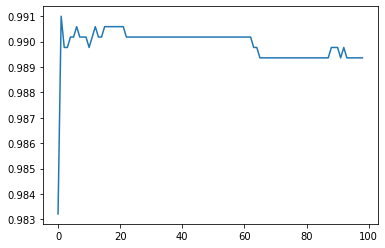

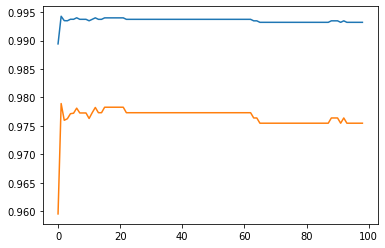

In [37]:
#grafico knee per accuracy
plt.plot(accuracy_list)
plt.show()

#grafico knee per f1 score
plt.plot(f1_list)
plt.show()

In [38]:
#Gridsearch per la scelta del miglior k
from sklearn.model_selection import GridSearchCV

kn = KNeighborsClassifier()
params = {
    'n_neighbors' : [10, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
grid_kn = GridSearchCV(estimator = kn,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_kn.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['auto'], 'n_neighbors': [10, 100],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [39]:
# extract best estimator
print(grid_kn.best_estimator_)
clf = KNeighborsClassifier(algorithm='auto', 
leaf_size=30, metric='minkowski',metric_params=None, n_jobs=-1, n_neighbors=25, p=2, weights='distance')
# to test the bestfit
print(grid_kn.score(X_test, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
0.9905853458862055


In [40]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='distance')

In [41]:
y_pred = clf.predict(X_test)

In [42]:
#KNN con il miglior k (25) ottenuto dai precedenti metodi

clf = KNeighborsClassifier(n_neighbors=25, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9901760130986492
F1-score [0.99373041 0.97731569]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.96      1.00      0.98       519

    accuracy                           0.99      2443
   macro avg       0.98      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



In [43]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9758 (+/- 0.030)
F1-score: 0.9668 (+/- 0.041)


In [132]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [54]:
#tentativo fallito di mettere su grafico

from sklearn import datasets
from matplotlib.colors import ListedColormap

n_neighbors = 25


# we only take the first two features. 
X = df.Temperature
y = df.Humidity


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])


clf = KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)
    

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
lt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

ValueError: Can only tuple-index with a MultiIndex

# NAIVE BAYES

In [46]:
from sklearn.naive_bayes import GaussianNB

In [154]:
#classificazione approssimando le variabili ad una distribuzione gaussiana
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [155]:
y_pred = clf.predict(X_test)

In [156]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9758493655341793
F1-score [0.98445323 0.94592117]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1925
         1.0       0.90      1.00      0.95       518

    accuracy                           0.98      2443
   macro avg       0.95      0.98      0.97      2443
weighted avg       0.98      0.98      0.98      2443



In [157]:
X_train_num, X_test_num, y_train, y_test = train_test_split(
    df[[c for c in df.columns if c != class_name]], df[class_name], 
       test_size=0.3, random_state=100, stratify=df[class_name])

In [158]:
clf = GaussianNB()
clf.fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9758493655341793
F1-score [0.98445323 0.94592117]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1925
         1.0       0.90      1.00      0.95       518

    accuracy                           0.98      2443
   macro avg       0.95      0.98      0.97      2443
weighted avg       0.98      0.98      0.98      2443



In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [49]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

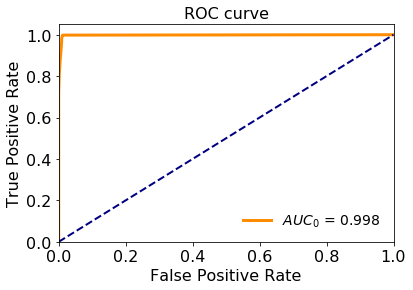

In [50]:
#ROC Curve

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()